In [25]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
#pylint:disable=no-member (Removes linting problems with cv)

In [26]:
IMG_size = (80,80)
channels = 1
char_path = r'./dataset/simpsons_dataset'

In [27]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

char_dict = caer.sort_dict(char_dict, descending=True)
char_dict


[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [28]:
characters = []
count = 0

for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [29]:
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_size, isShuffle=True)


[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.010752677917480469s
[INFO] At 1000 files
[INFO] 1454 files found in 0.003489971160888672s
[INFO] At 1000 files
[INFO] 1452 files found in 0.0050847530364990234s
[INFO] At 1000 files
[INFO] 1354 files found in 0.004004478454589844s
[INFO] At 1000 files
[INFO] 1342 files found in 0.0034818649291992188s
[INFO] At 1000 files
[INFO] 1291 files found in 0.004339456558227539s
[INFO] At 1000 files
[INFO] 1206 files found in 0.003032207489013672s
[INFO] At 1000 files
[INFO] 1194 files found in 0.0050160884857177734s
[INFO] At 1000 files
[INFO] 1193 files found in 0.008018016815185547s
[INFO] At 1000 files
[INFO] 1079 files found in 0.004395961761474609s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 23s


In [30]:
len(train)

13811

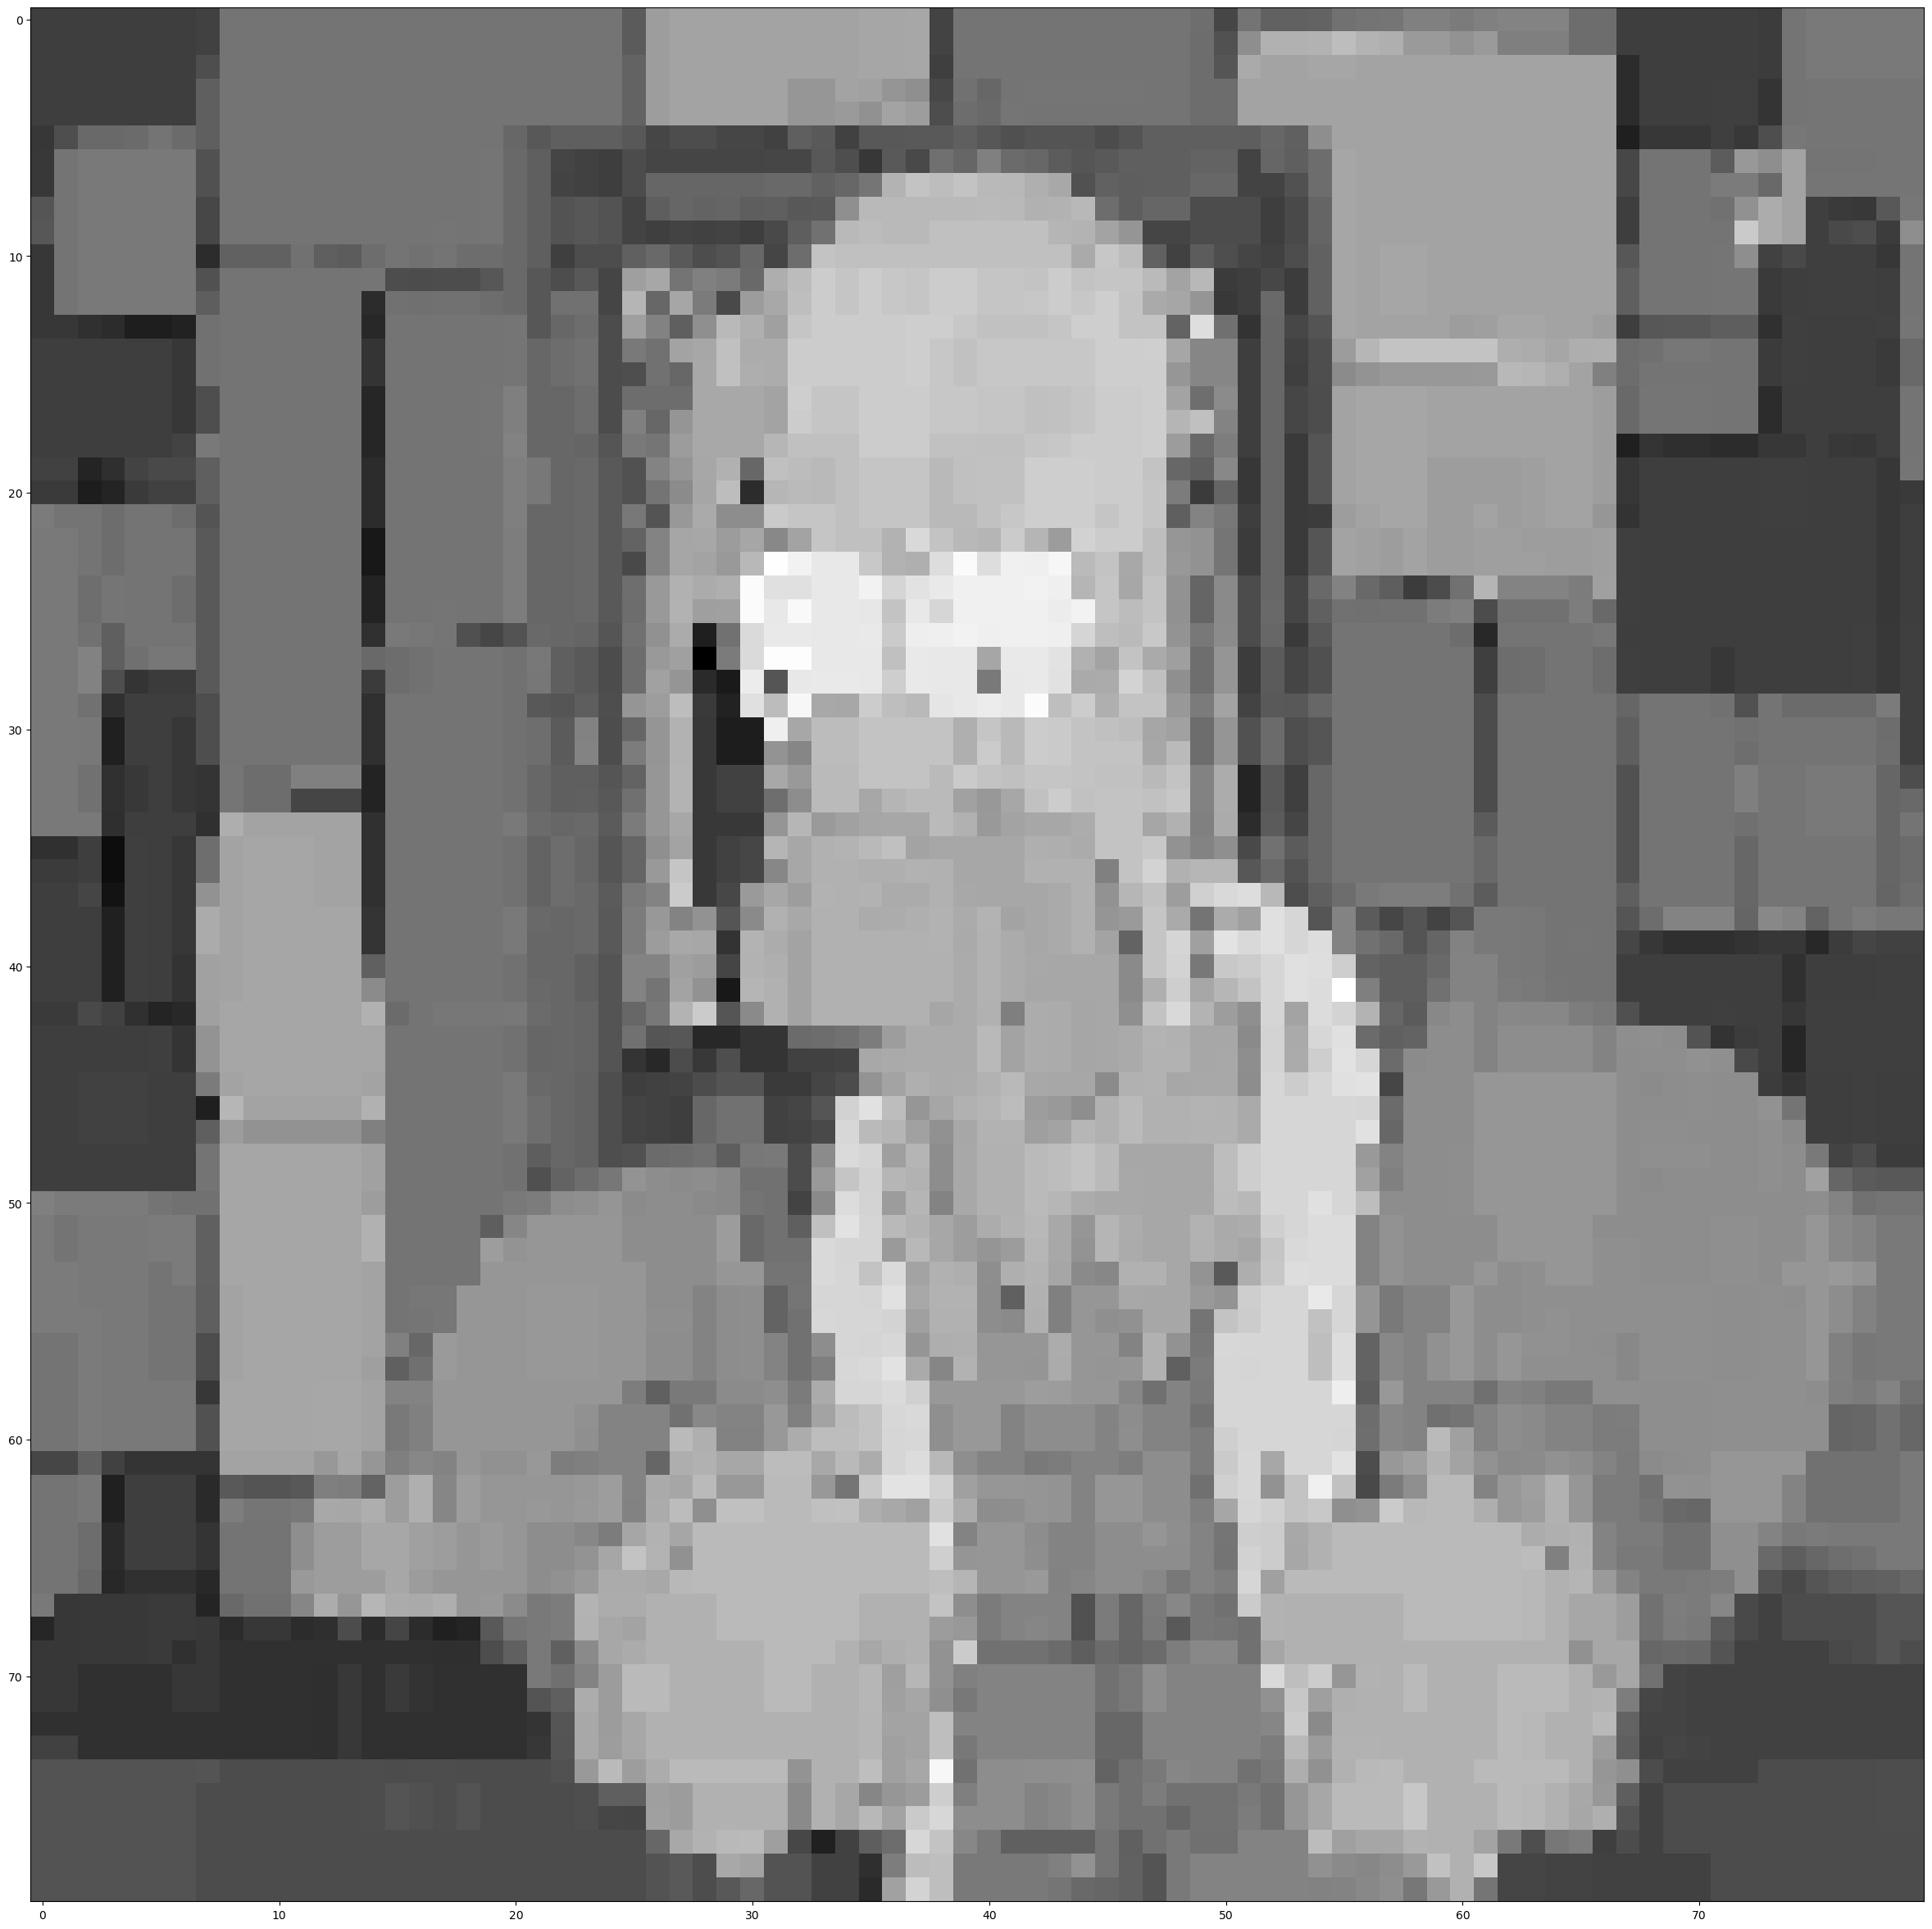

In [31]:

# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[2][0], cmap='gray')
plt.show()

In [32]:
feature_set , labels = caer.sep_train(train, IMG_SIZE=IMG_size)

In [33]:
import torch
from torch import nn
feature_set = caer.normalize(feature_set)
labels = torch.tensor(labels, dtype=torch.long)
labels = torch.nn.functional.one_hot(labels, len(characters)).float()
labels


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [34]:
X_train, X_val, y_train, y_val = caer.train_val_split(feature_set, labels, val_ratio=.2)

In [35]:

del train
del feature_set
del labels 
gc.collect()
# Deleted the train, feature_set, and labels variables to free up memory
# Freeing up memory to avoid potential memory leaks and ensure efficient use of resources

0

In [36]:

# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [37]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [38]:
import torch.nn.functional as F


In [39]:
w, h = IMG_size[:2]
import torch.optim as optim
class CNNModel(nn.Module):
    def __init__(self,input_channels,output_dim=10):
        super(CNNModel, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout2 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(64,256,kernel_size=3,padding=1)
        self.conv6 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout3 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * (w//8) * (h//8), 1024)
        self.fc2 = nn.Linear(1024, output_dim)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        x = F.softmax(x, dim=1)


        return x
    
model = CNNModel(input_channels = 1, output_dim=len(characters))




        

In [42]:
torch.save(model.state_dict(), 'simpsons_model.pt')

In [ ]:
# from torchsummary import summary

# summary(model, input_size=(channels, w, h))

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-7)
criterion = nn.BCEWithLogitsLoss()  # Use binary cross-entropy with logits for binary classification


In [ ]:
# Custom Dataset
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_val, y_val)

In [ ]:
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** (epoch // 30))  # Example of reducing the learning rate by a factor of 10 every 30 epochs

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

In [ ]:
# Training the model
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Permute the dimensions of the input tensor
        inputs = inputs.permute(0, 3, 1, 2)
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()

    scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Permute the dimensions of the input tensor
            inputs = inputs.permute(0, 3, 1, 2)
            
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%")

print("Training Complete")

RuntimeError: result type Float can't be cast to the desired output type Long